## **Import Libraries**

In [ ]:
#Pretrained Model Inception without Top Layer
# !wget "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [ ]:
#Export Dataset from .zip
import zipfile

zip_file = '/content/drive/MyDrive/Skinalyze(2)/Dataset_4/Dataset_5.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('/content/drive/MyDrive/Skinalyze(2)/Dataset_4')
zip_ref.close()

In [ ]:
import os
import random
import shutil
from shutil import copyfile
import numpy as np
from io import BytesIO

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Plotting and dealing with images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Interactive widgets for Upload
from ipywidgets import widgets

# **Load Dataset**

In [ ]:
#Count total images of train and validation data from the dataset

TRAINING_DIR = "/content/drive/MyDrive/Skinalyze(2)/Dataset_4/train/"
VALIDATION_DIR = "/content/drive/MyDrive/Skinalyze(2)/Dataset_4/validation"

TRAINING_ACNE_DIR = os.path.join(TRAINING_DIR, "acne/")
VALIDATION_ACNE_DIR = os.path.join(VALIDATION_DIR, "acne/")
TRAINING_DRY_DIR = os.path.join(TRAINING_DIR, "dry/")
VALIDATION_DRY_DIR = os.path.join(VALIDATION_DIR, "dry/")
TRAINING_OILY_DIR = os.path.join(TRAINING_DIR, "oily/")
VALIDATION_OILY_DIR = os.path.join(VALIDATION_DIR, "oily/")
TRAINING_NORMAL_DIR = os.path.join(TRAINING_DIR, "normal/")
VALIDATION_NORMAL_DIR = os.path.join(VALIDATION_DIR, "normal/")

print("=====================\nTRAIN DATA PER CATEGORIES:\n")
print(f"Acne : {len(os.listdir(TRAINING_ACNE_DIR))} images")
print(f"Dry Skin : {len(os.listdir(TRAINING_DRY_DIR))} images")
print(f"Oily Skin : {len(os.listdir(TRAINING_OILY_DIR))} images")
print(f"Normal : {len(os.listdir(TRAINING_NORMAL_DIR))} images")

print("\n=====================\nVALIDATION DATA PER CATEGORIES:\n")
print(f"Acne : {len(os.listdir(VALIDATION_ACNE_DIR))} images")
print(f"Dry Skin : {len(os.listdir(VALIDATION_DRY_DIR))} images")
print(f"Oily Skin : {len(os.listdir(VALIDATION_OILY_DIR))} images")
print(f"Normal : {len(os.listdir(VALIDATION_NORMAL_DIR))} images")

TRAIN DATA PER CATEGORIES:

Acne : 300 images
Dry Skin : 300 images
Oily Skin : 300 images
Normal : 300 images

VALIDATION DATA PER CATEGORIES:

Acne : 100 images
Dry Skin : 100 images
Oily Skin : 100 images
Normal : 100 images


# **Preprocess Dataset Images**

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator(rescale=1./255.,
                                     rotation_range=20,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     shear_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale=1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(150, 150))

  return train_generator, validation_generator

In [ ]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 1200 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


# **Build Model**

In [ ]:
from tensorflow.keras.applications import MobileNetV2

pre_trained_model = MobileNetV2(input_shape=(150, 150, 3),
                         include_top=False,
                         weights='imagenet')  # atau None jika pakai custom weight

pre_trained_model.trainable = False

for layer in pre_trained_model.layers[:-30]:
    layer.trainable = False

<ipython-input-5-97adaa900e68>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained_model = MobileNetV2(input_shape=(150, 150, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# #Use pretrained model as transfer learning layers
# local_weight_file = '/content/drive/MyDrive/Skinalyze(2)/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# #Adjust input shape and weights
# pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
#                                 include_top = False,
#                                 weights = None)

In [ ]:
# # Load the downloaded pre-trained weights
# pre_trained_model.load_weights(local_weight_file)

# # Freeze the weights of the layers.
# for layer in pre_trained_model.layers:
#   layer.trainable = False

In [ ]:
# #Specify input layer model
# last_layer = pre_trained_model.get_layer('mixed7')
# print('last layer output shape: ', last_layer.output.shape)
# last_output = last_layer.output

In [ ]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = pre_trained_model(inputs, training=False)  # Memanggil Model Pretrained
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# Print the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.90):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    verbose=2,
    callbacks=[myCallback()]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
38/38 - 357s - 9s/step - accuracy: 0.3350 - loss: 1.6181 - val_accuracy: 0.4425 - val_loss: 1.3156
Epoch 2/100
38/38 - 43s - 1s/step - accuracy: 0.4942 - loss: 1.2069 - val_accuracy: 0.5450 - val_loss: 1.1762
Epoch 3/100
38/38 - 89s - 2s/step - accuracy: 0.5675 - loss: 1.0318 - val_accuracy: 0.5925 - val_loss: 1.1015
Epoch 4/100
38/38 - 45s - 1s/step - accuracy: 0.6092 - loss: 0.9373 - val_accuracy: 0.6150 - val_loss: 1.1117
Epoch 5/100
38/38 - 44s - 1s/step - accuracy: 0.6400 - loss: 0.8817 - val_accuracy: 0.6075 - val_loss: 1.1094
Epoch 6/100
38/38 - 45s - 1s/step - accuracy: 0.6467 - loss: 0.8800 - val_accuracy: 0.6325 - val_loss: 1.0526
Epoch 7/100
38/38 - 45s - 1s/step - accuracy: 0.6817 - loss: 0.7793 - val_accuracy: 0.6375 - val_loss: 1.0172
Epoch 8/100
38/38 - 44s - 1s/step - accuracy: 0.6825 - loss: 0.7654 - val_accuracy: 0.6375 - val_loss: 1.0433
Epoch 9/100
38/38 - 44s - 1s/step - accuracy: 0.6925 - loss: 0.7468 - val_accuracy: 0.6550 - val_loss: 0.9997
Epoch 10/

# **Visualize Accuracy and Loss Value**

In [ ]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(len(train_acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, train_acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, train_loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

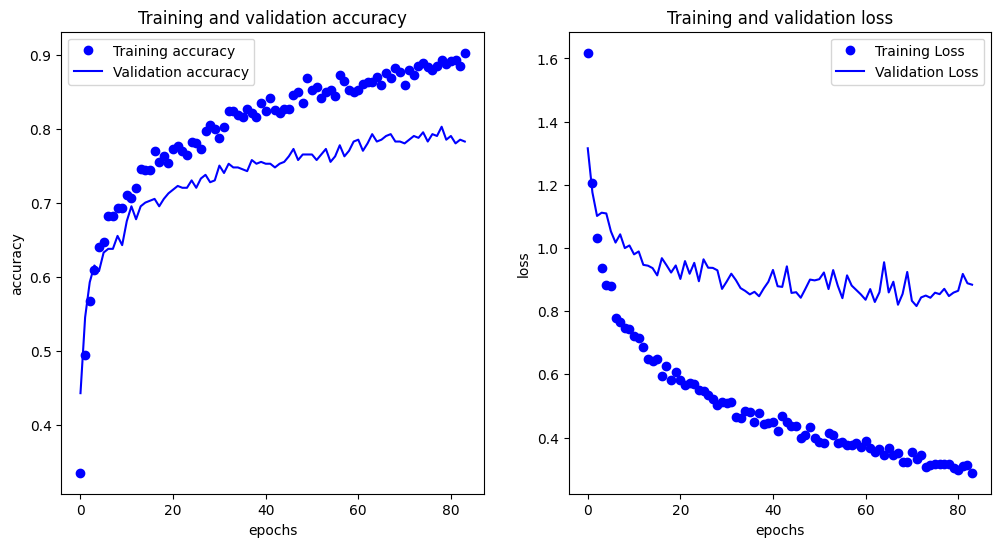

In [ ]:
plot_loss_acc(history)

# **Test The Model**

In [ ]:
# Save the model architecture in JSON format
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights in H5 format
model.save("skinalyze-model.h5")


In [ ]:
from tensorflow.keras.preprocessing import image
from google.colab import files

def predict_skin_condition(uploaded_image_path):
    img = image.load_img(uploaded_image_path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Normalize the image

    images = np.vstack([x])
    classes = model.predict(images, batch_size=32)
    print(classes)
    class_labels = ['acne', 'dry', 'normal', 'oily']
    predicted_class = np.argmax(classes)
    predicted_label = class_labels[predicted_class]
    print(f"Predicted Skin Condition: {predicted_label}")
    return predicted_label

# Upload the image
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  image_path = fn
  # Make prediction
  predicted_label = predict_skin_condition(image_path)


Saving acne 2.jpg to acne 2.jpg
User uploaded file "acne 2.jpg" with length 134058 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
[[0.0017496  0.297785   0.6790646  0.02140076]]
Predicted Skin Condition: normal
